# 2023 MLB Pitch Data - Merging, Cleaning, and Processing


In this notebook, we begin by reading in data which was accessed from Baseball Savant ([baseballsavant.mlb.com](https://baseballsavant.mlb.com)) using the `PyBaseball` package ([PyBaseball GitHub](https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md)) in the `2023 MLB Pitch Data - Month by Month Queries using Pybaseball` notebook and exported into `month1.csv, month2.csv, month3.csv, month4.csv, month5.csv, month6.csv`.

After merging that data into a single data frame, we join with umpire data obtained in the `2023 MLB Umpire Data` notebook, and then proceed to clean, process, and export our data.

## Importing Necessary Packages

We begin by importing `pandas`.

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

## Reading In Data

Next, we read in the data obtained in `2023 MLB Pitch Data - Month by Month Queries using Pybaseball` notebook and merge these data frames together.

In [2]:
month1 = pd.read_csv("month1.csv")
month2 = pd.read_csv("month2.csv")
month3 = pd.read_csv("month3.csv")
month4 = pd.read_csv("month4.csv")
month5 = pd.read_csv("month5.csv")
month6 = pd.read_csv("month6.csv")

In [5]:
month_list = [month1, month2, month3, month4, month5, month6]

full_season = pd.concat(month_list, ignore_index=True)

## Restricting to Pitch Events Which Are Either Balls or Called Strikes

We are interested in umpire decision making, so we restrict to pitches where the umpire has to actively make a ball/strike call.

In [6]:
full_season_bs = full_season[full_season['description'].isin(['ball', 'called_strike'])]

## Restricting Features I

We now make several helpful lists of features:
* `info_cols` - features that are necessary for data cleaning and processing, but which will be dropped before exporting;
* `core_cols` - essential pitch location and strike zone location features;
* `extra_cols` - the features of `core_cols` plus all other relevant features;
* `join_cols` - the features of `core_cols` plus the features of `extra_cols`.

In [ ]:
# uncomment the code below to get see the full list of columns

# all_cols = full_season_bs.columns.to_list()
# all_cols

In [ ]:
info_cols = ['game_date', 'home_team', 'game_pk', 'type', 'description']

core_cols = ['zone', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']

extra_cols = ['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'outs_when_up']
extra_cols.extend(['inning', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate'])
extra_cols.extend(['release_extension', 'release_pos_y', 'at_bat_number', 'pitch_number', 'home_score', 'away_score'])

extra_cols = core_cols + extra_cols

join_cols = info_cols + extra_cols

We now restrict to the features in `join_cols`, which removes all features which are entirely irrelevant.

In [8]:
ready_to_join = full_season_bs[join_cols]

## Joining with Umpires

We scraped umpire information from Baseball Reference in the `2023 MLB Umpire Data` and exported it in `umpires.csv`. We now read in `umpire.csv` and join it with the `ready_to_join` data frame.

In [11]:
umpires = pd.read_csv('umpires.csv')

left_join = pd.merge(ready_to_join, umpires, on=['game_date', 'home_team'], how='left')

As we can see below, 348,126 of the 358,606 rows have non-null umpire values, which (primarily) come from doubleheader games.

In [14]:
left_join.umpire.info()

<class 'pandas.core.series.Series'>
Int64Index: 358606 entries, 0 to 358605
Series name: umpire
Non-Null Count   Dtype 
--------------   ----- 
348126 non-null  object
dtypes: object(1)
memory usage: 5.5+ MB


### Doubleheaders

The following code records the values of `game_pk` with null umpire entries and exports the relevant information as `missing_umpires.csv`. Since this problem has already been addressed, we comment out the code below.

In [15]:
#missing_umpires = list(left_join[left_join['umpire'].isnull()].game_pk.unique())

In [16]:
#missing_umpires_df = left_join[left_join['game_pk'].isin(missing_umpires)][['game_date', 'home_team', 'game_pk']].drop_duplicates().sort_values(by=['home_team','game_date','game_pk'])

In [17]:
#missing_umpires_df.to_csv('missing_umpires.csv', index=False)

Having scraped the umpire information for the 10,480 pitches with missing umpire information, we now read in `missing_umpires_return.csv`and use it to fill in our missing entries.

In [18]:
missing_umpires_return = pd.read_csv('missing_umpires_return.csv')

In [19]:
missing_game_pks = missing_umpires_return.game_pk.to_list()

for counter in range(len(missing_game_pks)):
    umpire = missing_umpires_return.at[counter, 'umpire']
    game_id = missing_game_pks[counter]
    game_indices = left_join[left_join['game_pk']==game_id].index.to_list()
    for index in game_indices:
        left_join.at[index, 'umpire'] = umpire

Below we verify that all umpire entries are now non-null

In [20]:
left_join.umpire.info()

<class 'pandas.core.series.Series'>
Int64Index: 358606 entries, 0 to 358605
Series name: umpire
Non-Null Count   Dtype 
--------------   ----- 
358606 non-null  object
dtypes: object(1)
memory usage: 13.5+ MB


## Minor Feature Engineering

### Addressing `type` and `description`

We begin by clarifying the `type` feature, which records whether the pitch was a ball (B) or strike (S). Baseball Savant also includes a ball in play option (X). Note that `description` provides more granular information, but since we have already used `description` to reduce to balls and called strikes, we can remove `description` and rename `type` to be more clear in this context.

In [22]:
left_join = left_join.rename(columns={'type':'ball/strike'})

When modeling, it will be helpful to have balls and strikes as a binary variable, so we add such a column here.

In [23]:
binary_bs_list = []

for counter in left_join.index:
    if left_join.at[counter, 'ball/strike']=='B':
        binary_bs_list.append(0)
    else:
        binary_bs_list.append(1)

left_join = left_join.assign(binary_bs=binary_bs_list)

### Heart, Shadow, Chase, and Waste

The `zone` feature breaks up the region of where a pitch lands, with 1-9 being in the strike zone and 11-14 being outside the strike zone; these are based on the regulation strike zone.

It will be helpful for us to include a slightly different presentation of this region. Baseball Savant's [Statcast Swing Take](https://baseballsavant.mlb.com/visuals/swing-take?playerId=545361) tool describes four regions: the heart, shadow, chase, and waste regions. They are most succinctly presented with the following visual which is linked to from the Swing Take tool ([link](https://tangotiger.net/strikezone/zone%20chart.png)): 

Additionally, while we have the umpire's call, we will also need to determine if the pitch was in the regulation strike zone or not. We do that now as well.

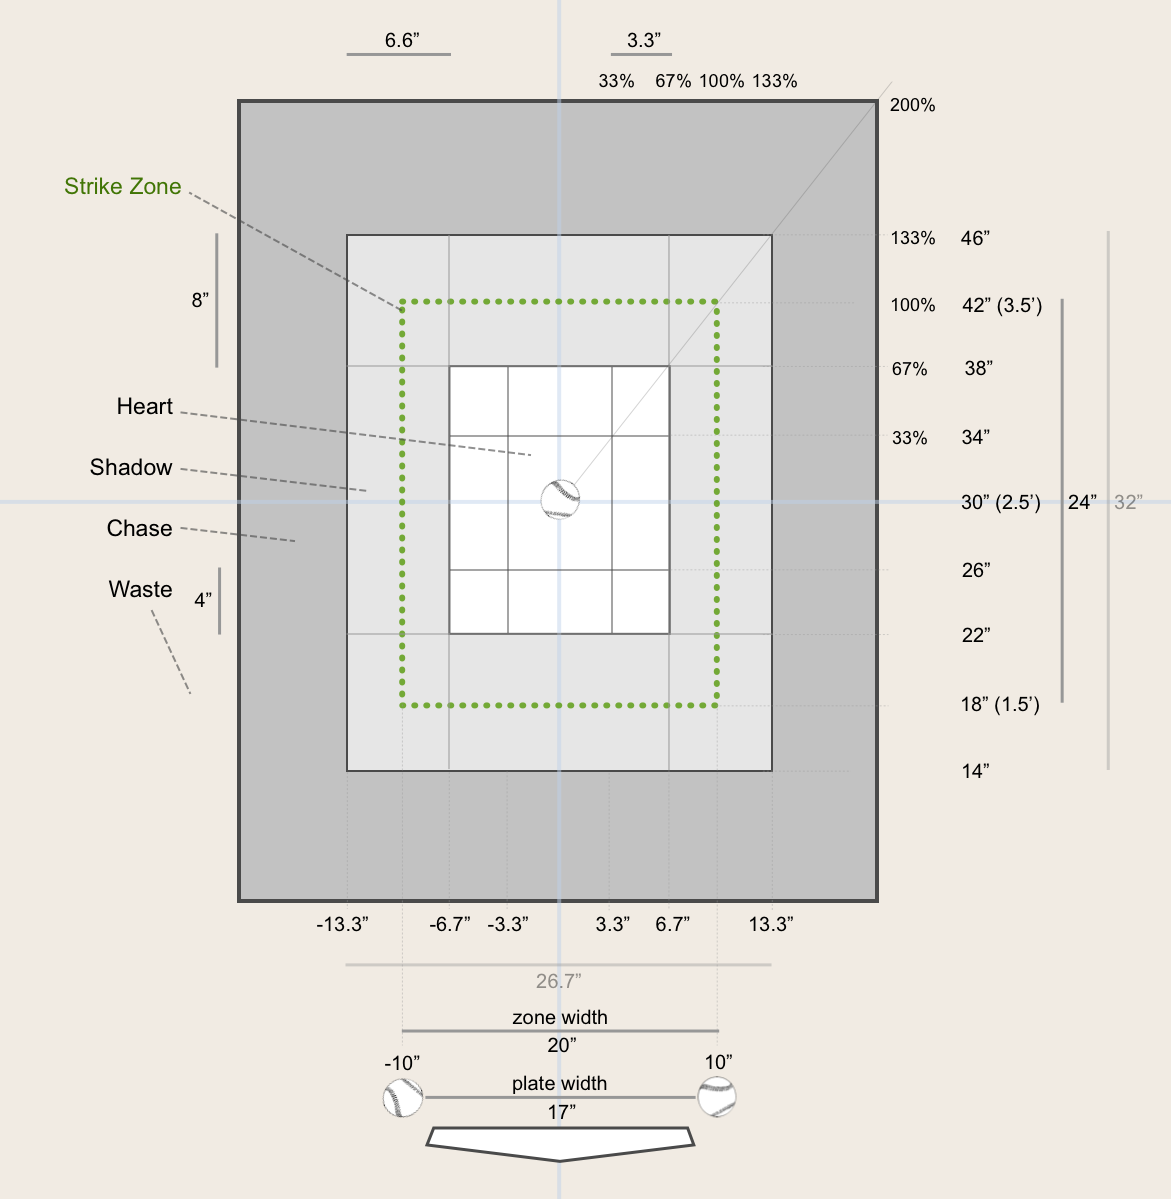

In [24]:
from IPython.display import Image
Image("heart_shadow_chase_waste.png")

We note that `plate_x` and `plate_z` are given in feet. Since the x measurements for heart, shadow, chase, and waste are in inches, we will scale `plate_x` values by 12. Since the top and bottom of the strike zone depend on the batter and are given in terms of percentages, we do not need to scale `plate_z` values. 

However, we first need to check for null values of `plate_x` and `plate_z`.

In [25]:
left_join.plate_x.info()

<class 'pandas.core.series.Series'>
Int64Index: 358606 entries, 0 to 358605
Series name: plate_x
Non-Null Count   Dtype  
--------------   -----  
358481 non-null  float64
dtypes: float64(1)
memory usage: 13.5 MB


In [26]:
left_join.plate_z.info()

<class 'pandas.core.series.Series'>
Int64Index: 358606 entries, 0 to 358605
Series name: plate_z
Non-Null Count   Dtype  
--------------   -----  
358481 non-null  float64
dtypes: float64(1)
memory usage: 13.5 MB


Given that 358,481 of the 358,606 pitches have non-null entries for `plate_x` and for `plate_z`, we simply restrict to pitches with non-null values.

In [27]:
left_join = left_join[(left_join['plate_x'].notnull()) & (left_join['plate_z'].notnull())]

Additionally, to determine true balls and strikes, we need information on the top and bottom of the strike zone. Consequently, we similarly check for null values of `sz_top` and `sz_bot`.

In [28]:
left_join.sz_top.info()

<class 'pandas.core.series.Series'>
Int64Index: 358481 entries, 0 to 358605
Series name: sz_top
Non-Null Count   Dtype  
--------------   -----  
358481 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [29]:
left_join.sz_bot.info()

<class 'pandas.core.series.Series'>
Int64Index: 358481 entries, 0 to 358605
Series name: sz_bot
Non-Null Count   Dtype  
--------------   -----  
358481 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


As seen above, there are no null values of `sz_top` and `sz_bot` and we can proceed appropriately.  
  
While determining heart / shadow / chase / waste, we also determine if each pitch was or was not within the regulation strike zone and create the `true_ball/strike` feature.

In [30]:
hscw_list = []
true_bs_list = []

for counter in left_join.index:
    x = 12*left_join.at[counter, 'plate_x']
    z = left_join.at[counter, 'plate_z']
    top = left_join.at[counter, 'sz_top']
    bot = left_join.at[counter, 'sz_bot']
    mid = (top+bot)/2
    unit = top-mid
    heart_adj = (2/3)*unit
    shadow_adj = (4/3)*unit
    chase_adj = 2*unit
    if (-6.7 <= x <= 6.7) and (mid-heart_adj <= z <= mid+heart_adj):
        hscw_list.append('heart')
    elif (-13.3 <= x <= 13.3) and (mid-shadow_adj <= z <= mid+shadow_adj):
        hscw_list.append('shadow')
    elif (-20 <= x <= 20) and (mid-chase_adj <= z <= mid+chase_adj):
        hscw_list.append('chase')
    else:
        hscw_list.append('waste')
    if (-10 <= x <= 10) and (bot <= z <= top):
        true_bs_list.append('true_strike')
    else:
        true_bs_list.append('true_ball')

In [31]:
left_join = left_join.assign(hscw=hscw_list, new=true_bs_list)

In [32]:
left_join = left_join.rename(columns={'new':'true_ball/strike'})

### Umpire Call vs Regulation Zone

Next, we introduce a new feature `correct_call` which tracks whether an umpire's call on a specific pitch matches the regulation strike zone.

In [33]:
cc_list = []

for counter in left_join.index:
    call = left_join.at[counter, 'ball/strike']
    actual = left_join.at[counter, 'true_ball/strike']
    if (call=='S') and (actual=='true_strike'):
        cc_list.append('correct_call')
    elif (call=='B') and (actual=='true_ball'):
        cc_list.append('correct_call')
    else:
        cc_list.append('incorrect_call')

In [34]:
left_join = left_join.assign(correct_call=cc_list)

### `plate_x` as a Vector

Recall that `plate_x` is the horizontal location of a pitch, with a value of zero being in the middle of the plate. Values between -0.833 and 0.833 (or, more precisely, -10/12 and 10/12) are possible strikes (depending on the vertical location of the pitch), whereas values outside that range are balls. Given how logitic regression models work, it is helpful to replace `plate_x` with two features instead: `plate_x_mag` (the magnitude/absolute value of `plate_x`) and `plate_x_dir` (the sign of `plate_x`).

In [35]:
mag_list = []
dir_list = []

for counter in left_join.index:
    plate_x_val = left_join.at[counter, 'plate_x']
    mag_list.append(abs(plate_x_val))
    if plate_x_val < 0:
        dir_list.append('neg')
    elif plate_x_val == 0:
        dir_list.append('zero')
    else:
        dir_list.append('pos')

In [36]:
left_join = left_join.assign(plate_x_mag=mag_list, plate_x_dir=dir_list)

## Restricting Features II

We first restrict the columns of our data frame with umpire information to those which will be considered in our main notebook.

In [38]:
extra_cols.insert(0,'ball/strike')
extra_cols.insert(1,'binary_bs')
extra_cols.insert(2,'true_ball/strike')
extra_cols.insert(3, 'correct_call')
extra_cols.insert(5,'hscw')
extra_cols.insert(7,'plate_x_mag')
extra_cols.insert(8,'plate_x_dir')
extra_cols.extend(['umpire'])

extra_df = left_join[extra_cols]

Next, we restrict the columns of our data frame with umpire information to only those which will be considered when dealing with pitch location.

In [40]:
core_cols.insert(0,'ball/strike')
core_cols.insert(1,'binary_bs')
core_cols.insert(2,'true_ball/strike')
core_cols.insert(3, 'correct_call')
core_cols.insert(5,'hscw')
core_cols.insert(7,'plate_x_mag')
core_cols.insert(8,'plate_x_dir')
core_cols.extend(['umpire'])

core_df = left_join[core_cols]

Finally, we export these data frames as CSVs to be used in the main notebook.

In [42]:
extra_df.to_csv('large_model_data.csv', index=False)
core_df.to_csv('small_model_data.csv', index=False)